In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import json
from collections import defaultdict
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from tqdm import tqdm
Image.MAX_IMAGE_PIXELS = None

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)

In [3]:
from lib.utilities_alignment import (create_warp_transforms, parse_elastix)

In [4]:
animal = 'DK55'
downsample_factor = 32
CSV_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}'

In [5]:
IMG_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
cshl_csvfile = 'cshl.premotor.csv'
cshl_csvpath = os.path.join(CSV_PATH, cshl_csvfile)
cshl_df = pd.read_csv(cshl_csvpath, names=['section','x','y'])

In [6]:
sections = cshl_df['section'].unique().tolist()

In [7]:
section_size = {}
for section in sections:
    filename = str(section).zfill(3) + '.tif'
    filepath = os.path.join(IMG_PATH, 'CH3/full', filename)
    input_image = Image.open(filepath)
    rotated_height = input_image.width
    section_size[section] = rotated_height
    input_image.close()

In [8]:
for index, row in cshl_df.iterrows():
    section = row['section']
    rotated_height = section_size[section]
    cshl_df.at[index,'xp'] = cshl_df.at[index,'y'] 
    cshl_df.at[index,'yp'] = rotated_height - cshl_df.at[index,'x'] 

In [9]:
cshl_df.head()

,section,x,y,xp,yp
0,221,22359,21440,21440.0,7424.0
1,221,22359,21456,21456.0,7424.0
2,221,21751,21184,21184.0,8032.0
3,221,22039,21184,21184.0,7744.0
4,221,21815,21024,21024.0,7968.0


## Get the annotation points

In [10]:
section_vertices = defaultdict(list)
for index, row in cshl_df.iterrows():
    section = row['section']
    x = row['xp']
    y = row['yp']
    section_vertices[section].append([x,y])

## Reproduce create_clean transform

In [11]:
# find the difference between the image stack size which is consistent for all images
# and the individual shape of the aligned image: use thumbnail 
INPUT = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH3/thumbnail'
section_offset = {}

# original image is long and narrow with the brain stem at the bottom
width = 60000
height = 34000
downsample_factor = 32
aligned_shape = np.array((width, height)) / downsample_factor
print(aligned_shape)

for file_name in sorted(os.listdir(INPUT)):
    filepath = os.path.join(INPUT, file_name)    
    input_image = Image.open(filepath)
    width = input_image.width
    height = input_image.height
    downsampled_shape = np.array((width, height))
    difference = np.round(aligned_shape - downsampled_shape)
    section = int(file_name.split('.')[0])
    section_offset[section] = difference / 2

[1875.  1062.5]


In [23]:
#section_vertices[224]

## Reproduce create_alignment transform

In [13]:
transforms = parse_elastix(animal)
downsample_factor = 32
warp_transforms = create_warp_transforms(animal, transforms, downsample=True)
ordered_transforms = sorted(warp_transforms.items())

section_transform = {}
for filename, transform in ordered_transforms:
    section_num = int(filename.split('.')[0])
    transform = np.linalg.inv(transform) 
    section_transform[section_num] = transform

## Alignment of annotation coordinates

In [14]:
'''
(x', y') = (x * sx + y * ry + tx, x * rx + y * sy + ty)
'sx': T[0, 0], 'sy': T[1, 1], 'rx': T[1, 0], 'ry': T[0, 1], 'tx': T[0, 2], 'ty': T[1, 2]
'''
def transform_create_alignment(points, transform):
    a = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.T[:, 0:2]
    c = np.matmul(a, b)
    return c

aligned_section_structure_polygons = defaultdict(list)
for section, vertices in section_vertices.items():
    points = np.array(vertices) / downsample_factor
    points = points + section_offset[section] # create_clean offset
    points = transform_create_alignment(points, section_transform[section]) # create_alignment transform
    aligned_section_structure_polygons[section] = [points]
    

In [15]:
data = []
for section,v in aligned_section_structure_polygons.items():
    for x,y in v[0]:
        data.append([x,y,section])    

df = pd.DataFrame(data, columns=['x','y','section'])
df = df.astype({'section':'int32','x': 'float64', 'y':'float64'})
outfile = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/DK55/cshl2dk.aligned.csv'
#df.to_csv(outfile, index=False, header=False)
df.head()

,x,y,section
0,1159.086107,-117.090112,221
1,1159.586017,-117.080638,221
2,1150.727552,-98.245097,221
3,1150.898074,-107.243482,221
4,1145.766344,-100.339473,221


To this point, aligned_section_structure_polygons variable contains the aligned polygon vertices for each structure in each section. 
From now on, we introduce how to draw these points to numpy array or neuroglancer

686 193
707 203
1603 168
1598 179
1612 175
1619 181
1619 182
1740 197
1656 223
1715 201
1719 221
1655 265
1663 249
1679 246
1676 250
1679 247
1714 240
1771 231
1794 232
1646 292
1644 278
1699 283
1671 311
1682 313
1666 309
1669 317


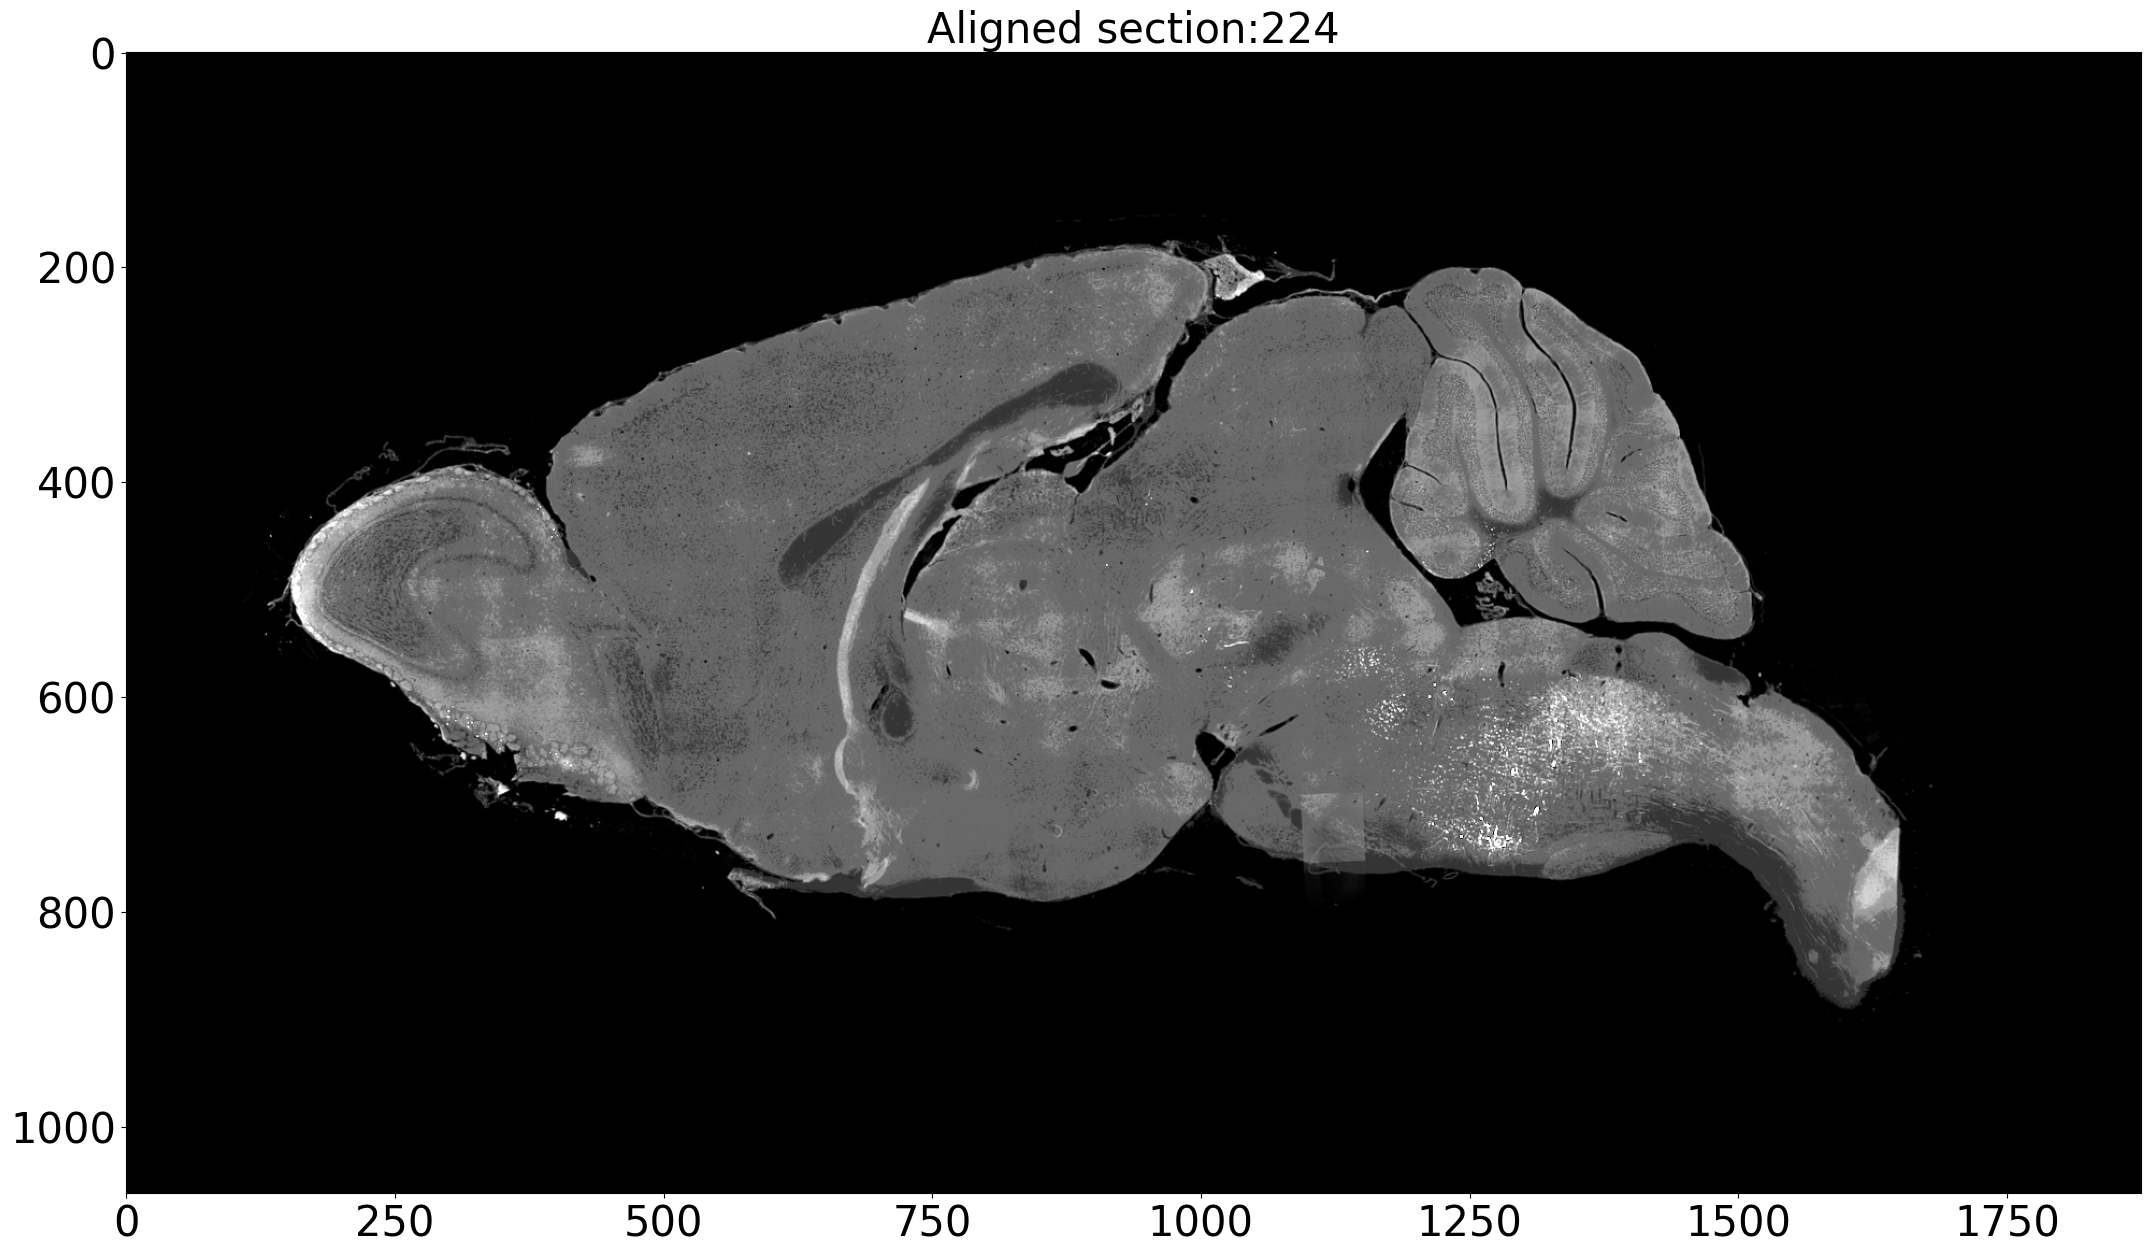

In [20]:
section = 224
filename = f'{str(section).zfill(3)}.tif'
INPUT = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK55/preps/CH3'
outpath = os.path.join(INPUT, '224.out.tif')
filepath = os.path.join(INPUT, 'thumbnail_aligned_norm', filename)
#filepath = os.path.join(INPUT, '224.norm.rotated.tif')
img = cv2.imread(filepath, -1)
#img = (img/256).astype(np.uint8)
#clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(4, 4))
#img = clahe.apply(img)

radius = 5
color = (0,255,1)
#df = cshl_df.copy()
df = df.loc[df['section'] == section]
for index, row in df.iterrows():
    x = round(row['x']) 
    y = round(row['y'])
    print(x,y)
    cv2.circle(img, (int(x), int(y)), radius, color, 2)

cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Aligned section:{}'.format(section), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()